In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

from pathlib import Path

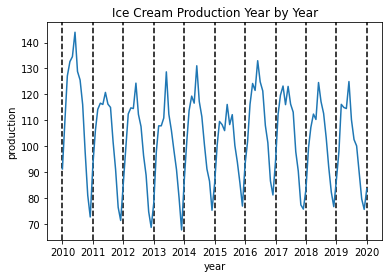

In [3]:
data = pd.read_csv(Path('data') / 'ice_cream.csv')
data.rename(columns={'DATE': 'date', 'IPN31152N': 'production'}, inplace=True)
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)
start_date = pd.to_datetime('2010-01-01')
data = data[start_date:]

plt.title('Ice Cream Production Year by Year')
plt.ylabel('production')
plt.xlabel('year')
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), 
                color='black',
                linestyle='--')
plt.plot(data.production)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

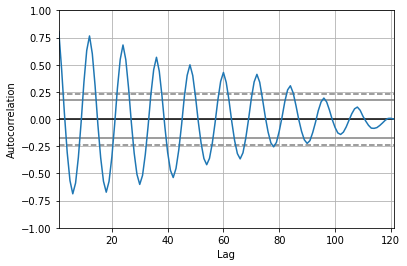

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot


# acf = plot_acf(data.production, lags=120) # 12 months * 10 years = 120 lags
autocorrelation_plot(data.production)

# Based on decaying ACF we're probably dealing with an autoregressive process 

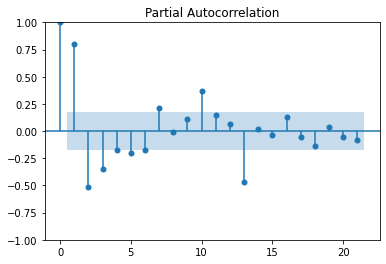

In [5]:
pacf = plot_pacf(data.production, method='ywm')

## Based on PACF we should start with an autoregressive model on lags 1, 2, 3, 10, 13

In [6]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split

# X = data.index.values
# y = data.production.values

train, test = data[:60].values, data[60:].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.1)

Coefficients: [ 7.26265493  0.9086358  -0.07295044 -0.16739223  0.2343183   0.01898743]


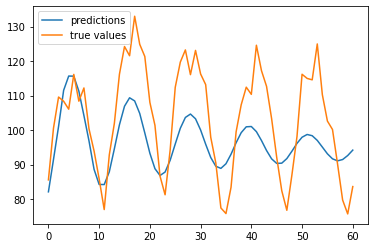

'MSE: 170.41588668164647'

In [7]:
from sklearn.metrics import mean_squared_error

model = AutoReg(train, lags=[1, 2, 3, 10, 13])
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print('Coefficients: %s' % model_fit.params)

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()
f'MSE: {mean_squared_error(predictions, test)}'

## now let's do the same thing assuming 12-months seasonality:

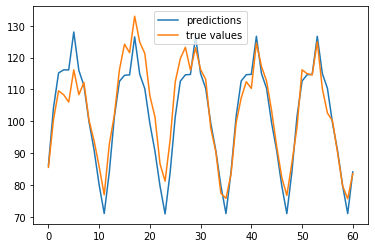

'MSE: 32.82205106561868'

In [8]:
model = AutoReg(train, lags=[1, 2, 3, 10, 13], seasonal=True, period=12)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# print('Coefficients: %s' % len(model_fit.params))

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()
f'MSE: {mean_squared_error(predictions, test)}'

In [9]:
# bingo... looks better and the MSE is way lower

### Dickey Fuller Test

In [10]:
from statsmodels.tsa.stattools import adfuller

# augmented dickey-fuller (for AR models more comlex than AR1)

adf_test_value, p_value, used_lags, nobs, _, _ = adfuller(data['production'].values)
print(f'''adf statistic: {adf_test_value} (lower than zero means no unit-roots)
p value: {p_value}''')

adf statistic: -3.469206803861127 (lower than zero means no unit-roots)
p value: 0.00881405532448749


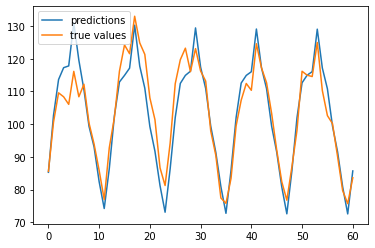

MSE: 30.722883903332164
using "number of lags" from the aug-dickey-fuller test helped!


In [11]:
# let's try to retrain the model with the number of lags produced by the augmented dickey-fuller
# test

model = AutoReg(train, lags=used_lags, seasonal=True, period=12)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# print('Coefficients: %s' % len(model_fit.params))

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()

print(f'''MSE: {mean_squared_error(predictions, test)}
using "number of lags" from the aug-dickey-fuller test helped!''')

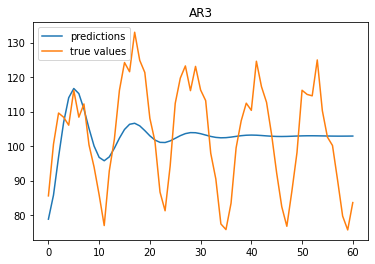

ARIMA MSE (AR3): 205.40624911313523


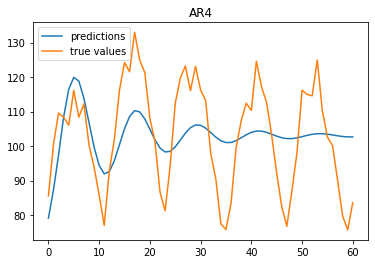

ARIMA MSE (AR4): 185.16803639886237


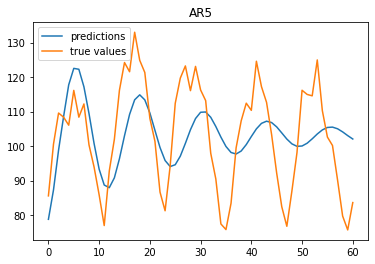

ARIMA MSE (AR5): 196.38586566960038


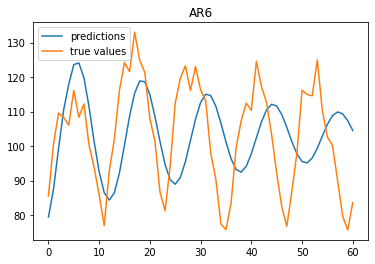

ARIMA MSE (AR6): 275.5781850397287


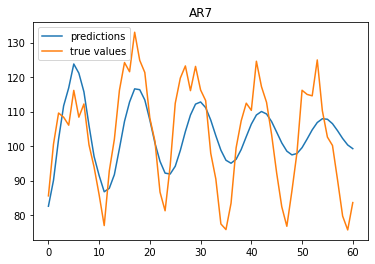

ARIMA MSE (AR7): 143.2670384976813


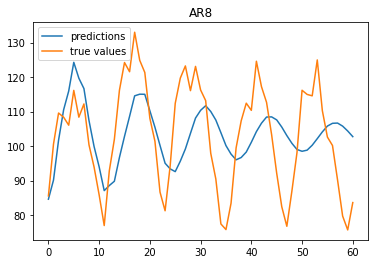

ARIMA MSE (AR8): 210.50333113354182


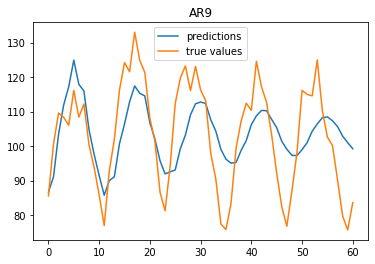

ARIMA MSE (AR9): 147.3143416334202


/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


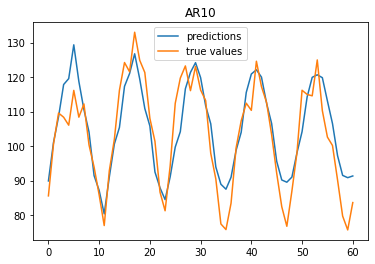

ARIMA MSE (AR10): 53.78253195297554


/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


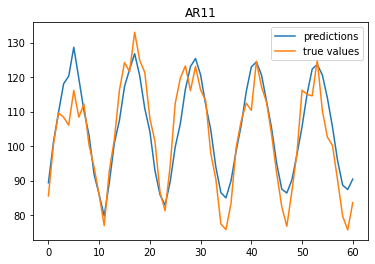

ARIMA MSE (AR11): 46.088839731925695


/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


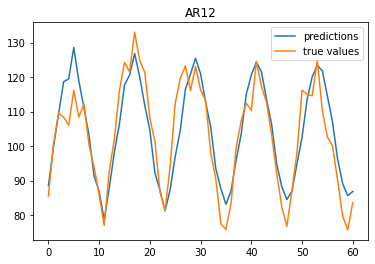

ARIMA MSE (AR12): 47.59562970360804


/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


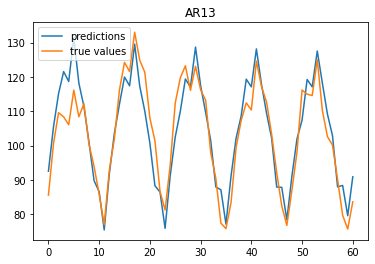

ARIMA MSE (AR13): 37.83366361399488


In [13]:
# ARMA model 
from statsmodels.tsa.arima.model import ARIMA

for i in range(3, 14):
    model = ARIMA(train, order=(i, 0, 0)) # hyperparams are AR-lags, diff-size, and MA-window-size
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
    plt.title(f'AR{i}')
    plt.plot(predictions, label='predictions')
    plt.plot(test, label='true values')
    plt.legend()
    plt.show()
    print(f'''ARIMA MSE (AR{i}): {mean_squared_error(predictions, test)}''')

In [14]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:                ARIMA(13, 0, 0)   Log Likelihood                -178.602
Date:                Wed, 24 Nov 2021   AIC                            387.204
Time:                        16:32:02   BIC                            418.620
Sample:                             0   HQIC                           399.493
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.0928      2.850     36.529      0.000      98.508     109.678
ar.L1          0.9310      0.119      7.806      0.000       0.697       1.165
ar.L2         -0.0951      0.179     -0.530      0.596      -0.447       0.257
ar.L3         -0.1103      0.178     -0.621      0.535      -0.459       0.238
ar.L4          0.0895      0.245      0.365      0.715      -0.391       0.570
ar.L5          0.0475      0.207      0.230      0.818      -0.358       0.453
ar.L6         -0.2986      0.127     -2.347      0.019      -0.548      -0.049
ar.L7          0.2526      0.168      1.504      0.133      -0.077       0.582
ar.L8         -0.0950      0.193     -0.493      0.622      -0.473       0.283
ar.L9         -0.1402      0.150     -0.933      0.351      -0.435       0.154
ar.L10         0.1938      0.186      1.039      0.299      -0.172       0.559
ar.L11        -0.0321      0.185     -0.174      0.862      -0.394       0.330
ar.L12         0.6645      0.139      4.767      0.000       0.391       0.938
ar.L13        -0.6150      0.106     -5.829      0.000      -0.822      -0.408
sigma2        15.2408      4.345      3.507      0.000       6.724      23.758
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.39   Prob(JB):                         0.73
Heteroskedasticity (H):               0.68   Skew:                             0.10
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plot Residuals

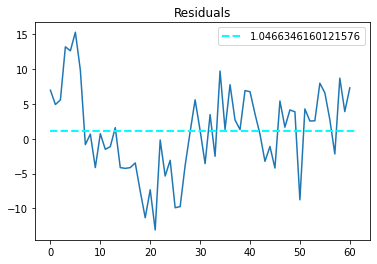

1.0466346160121576

In [15]:
residuals = predictions - test.reshape(-1)
plt.title("Residuals")
plt.plot(residuals)
plt.hlines(y=np.mean(residuals), xmin=0, xmax=len(residuals), colors='aqua', 
           linestyles='--', lw=2, label=np.mean(residuals))
plt.legend()
plt.show()
np.mean(residuals) # residuals mean close to zero good sign of extracting all meaninful signal

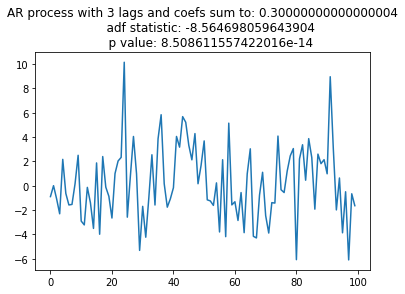

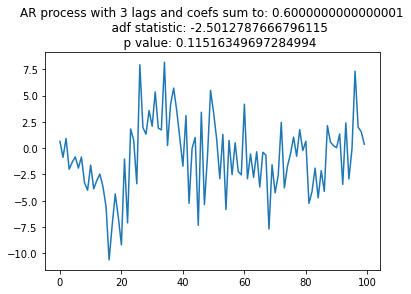

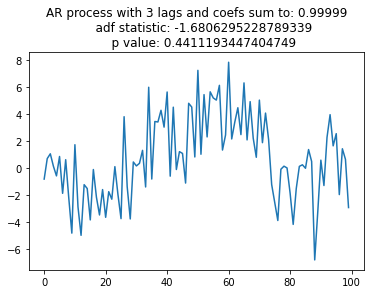

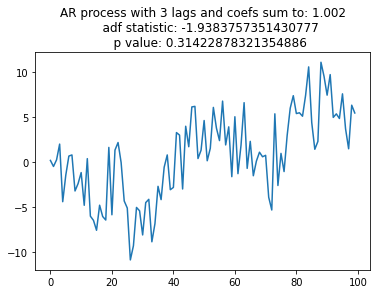

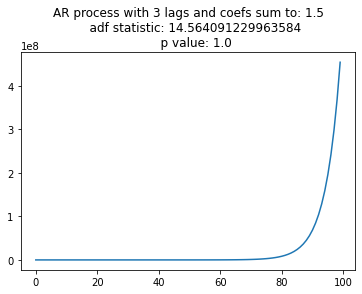

In [16]:
def generate_ar_process(lags: int, coefs: list[float], length: int) -> np.array:
    if len(coefs) != lags:
        raise ValueError(f'number of coefs ({len(coefs)}) must match lags: ({lags})')
        
    coefs = np.array(coefs)
    series = [np.random.normal() for _ in range(lags)] # generate first lags (normally distributed)
    
    for _ in range(length - lags):
        previous_values = series[-lags:][::-1] # take 'lags' values from in reversed order
        new_value = np.sum(np.array(previous_values) * coefs + np.random.normal())
        series.append(new_value)
    return np.array(series)

lags = 3
for coef in [0.1, 0.2, 0.33333, 0.334, 0.5]:
    coefs = [coef, coef, coef]
    generated_tseries = generate_ar_process(lags, coefs, 100)
    plt.title(f'''AR process with {lags} lags and coefs sum to: {sum(coefs)}
    adf statistic: {adfuller(generated_tseries)[0]}
    p value: {adfuller(generated_tseries)[1]}''')
    plt.plot(generated_tseries)
    plt.show()


### process remains stationary as long as sum of coefs is lower than 1
### when it's 1 and higher it gets a clean trend (trend-stationary?) 
### when it's significantly higher than 1 it become a smooth exponential 

# S&P500 

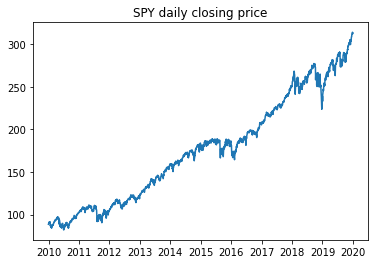

In [17]:
import yfinance 

spy_data = yfinance.Ticker('SPY')
spy_data = spy_data.history(period='1d', start='2010-01-01', end='2020-01-01')
closing_prices = spy_data[['Close']]
plt.title('SPY daily closing price')
plt.plot(closing_prices)
plt.show()

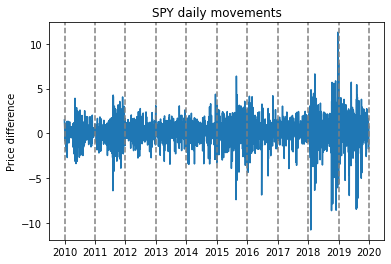

In [18]:
daily_diffs = closing_prices.values[1:] - closing_prices[:-1]
plt.title('SPY daily movements')
plt.ylabel('Price difference')
plt.plot(daily_diffs)
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle='--', color='gray')
plt.show()

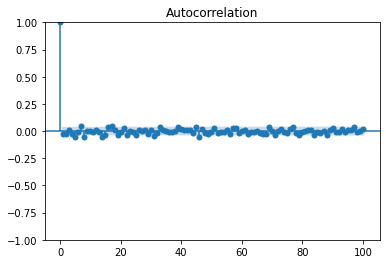

In [19]:
acf_plot = plot_acf(daily_diffs, lags=100)

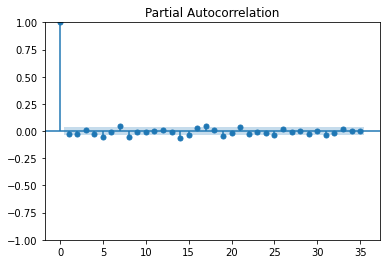

In [20]:
pacf_plot = plot_pacf(daily_diffs, method='ywm')

# no significant autocorrelation (predict stock-market movements is not easy)

In [21]:
def get_ticker_data(ticker: str, start_date: str = '1920-01-01', end_date: str = '2022-01-01', period='1d'):
    ticker_data = yfinance.Ticker(ticker)
    ticker_data = ticker_data.history(period='1d', start=start_date, end=end_date)
    if len(ticker_data) == 0:
        raise Exception(f'no data for: {ticker}')
    return ticker_data[['Close']]

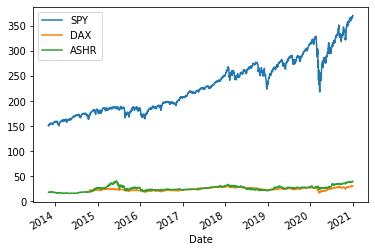

In [22]:
market_data = pd.DataFrame()
start, end = '2013-11-06','2021-01-01'
market_data['SPY'] = get_ticker_data('SPY', start_date=start, end_date=end)
market_data['DAX'] = get_ticker_data('DAX', start_date=start, end_date=end)
sse_index_tracking_fund = 'ASHR' #Xtrackers Hvst CSI 300 China A-Shs ETF
market_data[sse_index_tracking_fund] = get_ticker_data(sse_index_tracking_fund, start_date=start, end_date=end)
market_data.plot() # market_data.plot() and not plt.plot(market_data) to get labels automatically from cols
plt.legend()
plt.show()

In [23]:
market_data.corr() # correlation between markets seems between ~62% end ~66%

,SPY,DAX,ASHR
SPY,1.000000,0.656175,0.648154
DAX,0.656175,1.000000,0.624539
ASHR,0.648154,0.624539,1.000000


In [24]:
import scipy.stats as stats

def clean_mutual_nans(df: pd.DataFrame, col1: str, col2: str):
    return df[df[col2].notnull()][col1].dropna(), df[df[col1].notnull()][col2].dropna()

ashr, dax = clean_mutual_nans(market_data, 'ASHR', 'DAX')
r, p_value = stats.pearsonr(ashr, dax)
print('pearson r:', r, 'p value: ', p_value) 

r, p_value = stats.pearsonr(market_data.interpolate(method='time').fillna(method='bfill')['ASHR'],
                            market_data.interpolate(method='time').fillna(method='bfill')['DAX'])
print('(interpolated data) pearson r:', r, 'p value: ', p_value) 

pearson r: 0.6245391725577689 p value:  2.3001166011760126e-169
(interpolated data) pearson r: 0.6654840204233392 p value:  6.492441307570715e-231


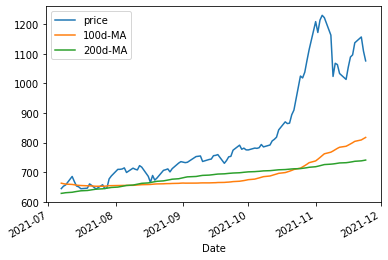

In [25]:
# plot moving averages
tsla_data = pd.DataFrame()
tsla_data['price'] = get_ticker_data('TSLA', start_date='2010-01-01', end_date='2022-01-01')
tsla_data['100d-MA'] = tsla_data['price'].rolling(100).mean()
tsla_data['200d-MA'] = tsla_data['price'].rolling(200).mean()
tsla_data.dropna()[-100:].plot()
plt.show()

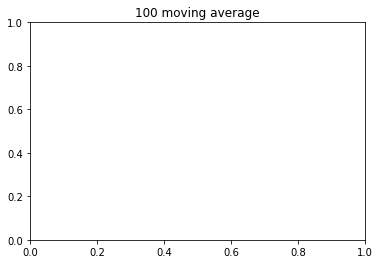

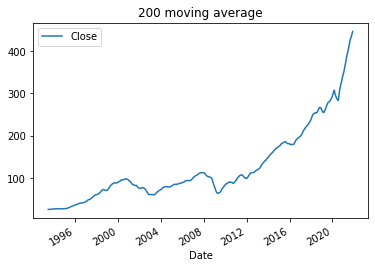

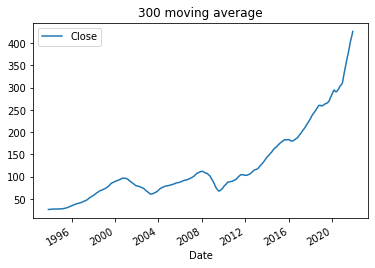

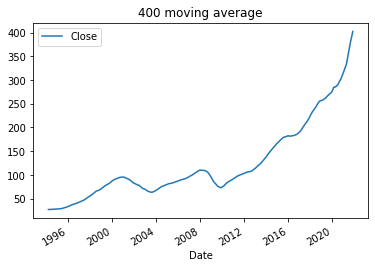

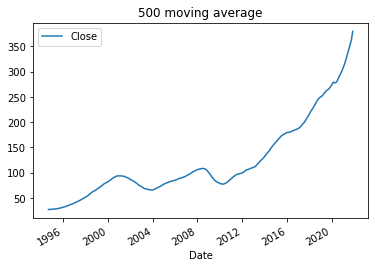

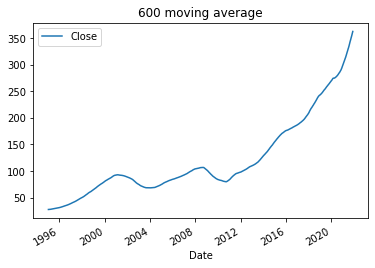

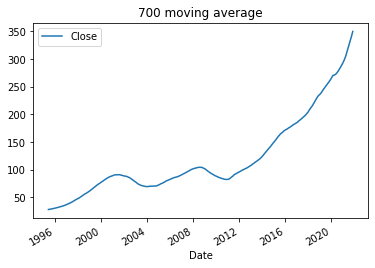

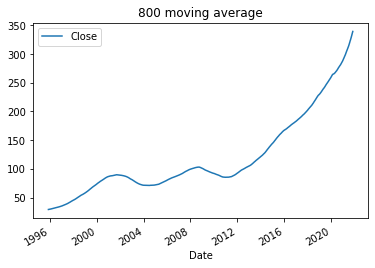

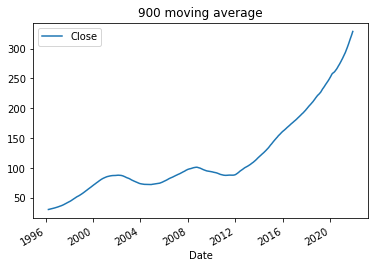

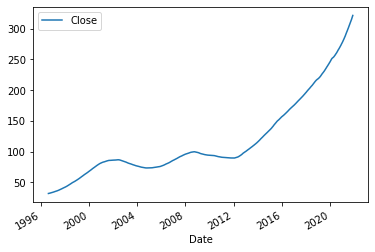

In [26]:
# moving average smoothing

spy_all_data = get_ticker_data('SPY', start_date='1993-01-01', end_date='2022-01-01')
for window in range(100, 1000, 100):
    plt.title(f'{window} moving average')
    ma_data = spy_all_data.rolling(window).mean().dropna()
    ma_data.plot()
    # reg_y = [pd.Timestamp(i).toordinal() for i in ma_data.index]
    # m, b = np.polyfit(reg_y, ma_data['Close'].values, 1)
    # x = np.array([1, 3, 5, 7])
    # plt.plot(x, x*m + b)
plt.show()

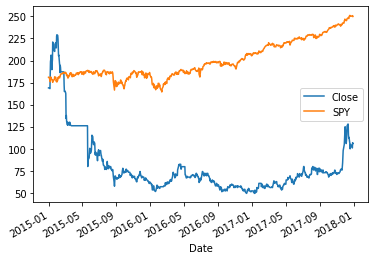

In [27]:
volatility_data = get_ticker_data('VIX', start_date='2015-01-01', end_date='2018-01-01').apply(lambda x: x / 100)
volatility_data['SPY'] = get_ticker_data('SPY', start_date='2015-01-01', end_date='2018-01-01')
volatility_data.plot()
plt.show()

In [28]:
def calc_roi(stock_price: pd.DataFrame):
    return stock_price.values[-1] / stock_price.values[0]

spy = get_ticker_data('SPY')
calc_roi(spy[pd.to_datetime('2020-12-01'):pd.to_datetime('2021-09-01')])

array([1.24774916])

## search for TLCC: Time Lagged Cross Correlation — assessing signal dynamics

In [29]:
spy, ashr = clean_mutual_nans(market_data, 'SPY', 'ASHR')
corr_df = pd.DataFrame()
for shift_periods in [10, 20, 30, 50]:
# shift_periods = 30
    corr_df['spy'] = spy
    corr_df['spy_shift'] = spy.shift(periods=shift_periods, freq='1D')
    corr_df['ashr'] = ashr
    corr_df['ashr_shift'] = ashr.shift(periods=shift_periods, freq='1D')
    assert corr_df.corr()['spy']['ashr_shift'] < corr_df.corr()['spy']['ashr']
    assert corr_df.corr()['ashr']['spy_shift'] < corr_df.corr()['ashr']['spy']
# doesn't look like there's some kind of TLCC...
corr_df.corr()

,spy,spy_shift,ashr,ashr_shift
spy,1.000000,0.964115,0.648154,0.576562
spy_shift,0.964115,1.000000,0.599461,0.601505
ashr,0.648154,0.599461,1.000000,0.844564
ashr_shift,0.576562,0.601505,0.844564,1.000000


In [31]:
assert corr_df.corr()['spy']['ashr_shift'] < corr_df.corr()['spy_shift']['ashr']
# also looks like more information is flowing from ashr to spy than the other way round 

In [107]:
# compare securities functionality 
def compare_securities(tickers: list[str], normalize_prices=True):
    raw_data = dict()
    for ticker in tickers:
        raw_data[ticker] = get_ticker_data(ticker)
    min_dates = []
    max_dates = []
    for df in raw_data.values():
        min_dates.append(df.index.min())
        max_dates.append(df.index.max())
    max_min = np.array(min_dates)[np.argmax(np.array(min_dates))]
    min_max = np.array(max_dates)[np.argmin(np.array(max_dates))]
    for ticker, data in raw_data.items():
        data = data[max_min:min_max]
        first_value = data['Close'].iloc[0].copy()
        data = data['Close'].apply(lambda x: x / first_value).values \
            if normalize_prices else data['Close'].values 
        print(f'performance for "{ticker}": {data[-1] / data[0]}')
        plt.plot(data, label=ticker)
    plt.legend()
    plt.show()

performance for "TSLA": 2.517918128960116
performance for "LCID": 5.0782706230617345
performance for "GM": 1.97000000968812


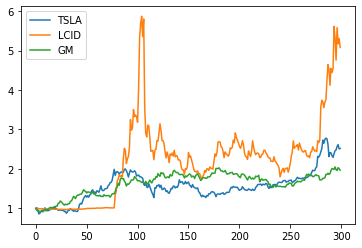

performance for "PLTR": 0.9431875836937345
performance for "HOOD": 0.8035611656365231
performance for "ARKK": 0.8777138544096929


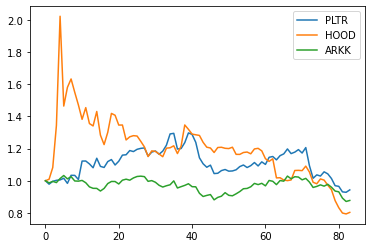

performance for "SPY": 6.301972401711392
performance for "SPXL": 40.43341759195427


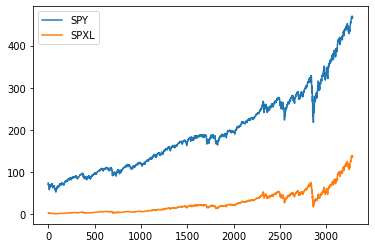

performance for "SPY": 6.302325567053415
performance for "SPXL": 40.44077556090344


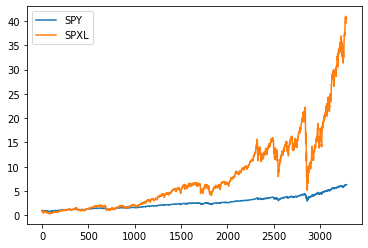

In [109]:
compare_securities(['TSLA', 'LCID', 'GM'])
compare_securities(['PLTR', 'HOOD', 'ARKK'])
compare_securities(['SPY', 'SPXL'], normalize_prices=False)
compare_securities(['SPY', 'SPXL'], normalize_prices=True)